Import packages

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Set global settings for better look and feel

In [23]:
pd.options.display.max_rows = 50
pd.options.display.max_columns = 30
#plt.style.use("seaborn-whitegrid")
sns.set_color_codes("muted")

Load dataset from given file to memory and set it's name as df

In [24]:
df = pd.read_csv("mkt_data.csv")
df[df["nb_units"]>=1]. head(10)

,id,send_date,estimated_age,age_range,channel,coupon,clicked,last_step,nb_units,order_value
70,71,2019-04-25,24,18-30,Email,2,1,purchased,1,38
116,117,2019-05-01,40,31-45,Email,2,1,purchased,3,114
531,532,2019-04-14,22,18-30,Email,4,1,purchased,2,72
658,659,2019-04-03,53,46-60,SMS,2,1,purchased,30,1194
664,665,2019-04-01,43,31-45,Email,4,1,purchased,1,36
774,775,2019-04-08,22,18-30,SMS,2,1,purchased,2,76
869,870,2019-04-30,54,46-60,Email,2,1,purchased,1,38
879,880,2019-04-02,37,31-45,Email,6,1,purchased,2,68
1016,1017,2019-04-07,23,18-30,Email,4,1,purchased,1,36
1157,1158,2019-04-29,33,31-45,Email,6,1,purchased,3,102


Base on additional information about the production cost and the
marketing campaigns.

---


*   Production cost for each razor is 18$.

*   Cost per one SMS is $0.050

*   Cost per one email sent is $0.075.

*   Each email or SMS will be supplied a coupon which can have value of 2$, 4$ or 6$. Coupon is
valid for up to 3 razors in each order. They have the option to wrap the items as gift. Ignore
wrapping and shipping costs.

*   The price without coupon is 40$ / razor.

Then add necessary columns for computing

In [25]:
df.insert(8,"is_purchased", df["last_step"].apply(lambda x: 1 if x == "purchased" else 0))

In [26]:
df.insert(5, "cost_per_SMS/Email", df["channel"].apply(lambda x: 0.05 if x == "SMS" else 0.075))

In [27]:
df["net_profit"] = df["order_value"]- df["nb_units"]* 18 - df["cost_per_SMS/Email"]

Compute:
- sum_of_net_profit: sum of net_profit
- ROI(Return on Investment) = ((Total sales - cost of good) - advertisting cost)/advertisting cost (include cost of sent SMS/email and cost of coupons for purchased orders)
- CVR(Conversion Rate) = sum of orders (or sum of customers who purchased) / sum of sent email and sms
- AOV(Average Order Value) = sum of order_values / sum of orders (or sum of customers who purchased)

In [28]:
analytical_df = df.groupby(["age_range","channel"]).apply(
    lambda x: pd.Series(
        {
            "sum_of_net_profit": x["net_profit"].sum(),
            "ROI": ((x["order_value"].sum() - x["nb_units"].sum()* 18 - x["cost_per_SMS/Email"].sum()) /\
                    (x["nb_units"].sum()*40 -x["order_value"].sum()+ x["cost_per_SMS/Email"].sum()))*100,
            "CVR": x["is_purchased"].sum()/x["channel"].count(),
            "AOV": x["order_value"].sum() / x["is_purchased"].sum()
        }
    )
).reset_index()
analytical_df.round(3)

C:\Users\hungl\AppData\Local\Temp\ipykernel_10952\1014528638.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analytical_df = df.groupby(["age_range","channel"]).apply(


,age_range,channel,sum_of_net_profit,ROI,CVR,AOV
0,18-30,Email,4408.500,90.421,0.006,56.791
1,18-30,SMS,11991.650,242.336,0.008,67.192
2,31-45,Email,12497.000,183.861,0.010,58.197
3,31-45,SMS,3507.000,80.676,0.003,71.805
4,46-60,Email,1418.925,61.132,0.005,53.948
5,46-60,SMS,8417.400,268.703,0.011,64.855
6,60+,Email,-751.100,-89.513,0.000,71.000
7,60+,SMS,-467.600,-68.005,0.000,61.667


Now, we plot some graphes for better visualizations for Metrics

Text(0.5, 1.0, 'AOV chart')

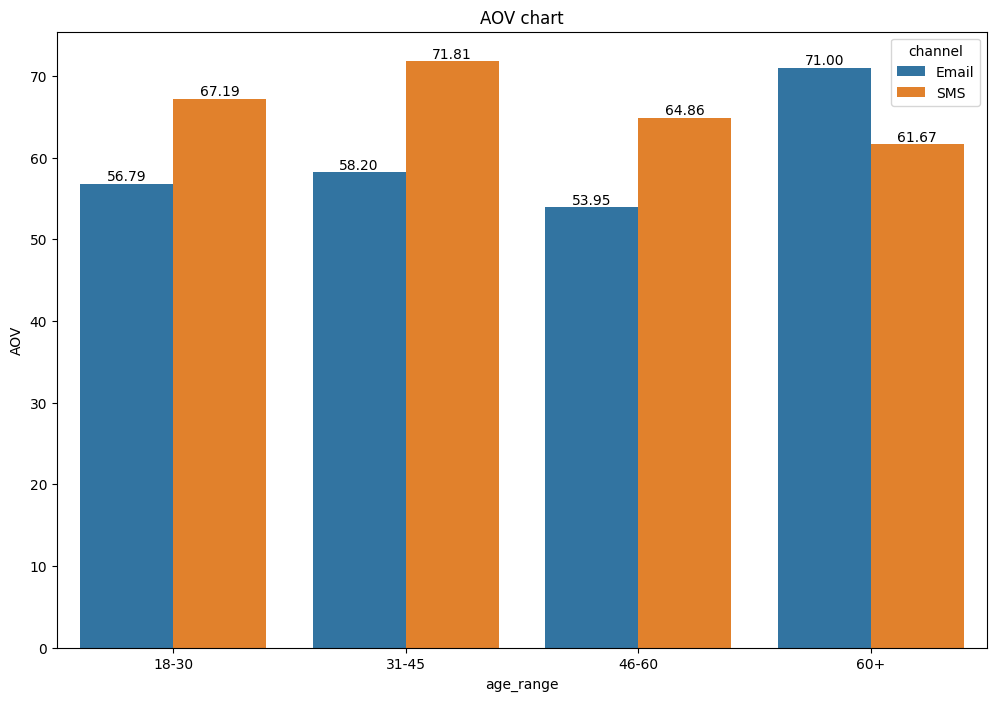

In [29]:
fig, ax = plt.subplots(figsize = (12,8))
AOV_barplot = sns.barplot(data= analytical_df, x = "age_range", y = "AOV", hue="channel")
for i in AOV_barplot.containers:
    AOV_barplot.bar_label(i,fmt = "%.2f",label_type="edge")
plt.title("AOV chart")

Comments:
This chart describes the Average Order Value of each customer segment and each channel
As we can see from the chart, the AOV is pretty common in each customer segment and each channel, exclude Customer group 60+ (but diference is little).
=> So that, we can ignore this element.

Text(0.5, 1.0, 'sum_of_net_profit chart')

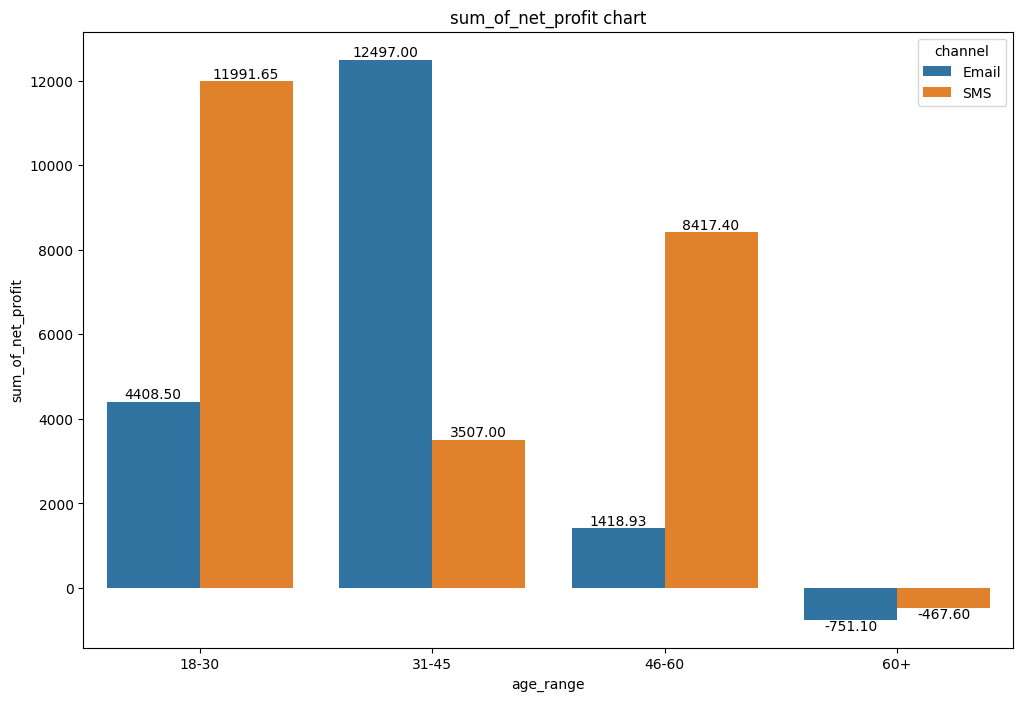

In [30]:
fig, ax = plt.subplots(figsize = (12,8))
sum_of_net_profit_barplot = sns.barplot(data=analytical_df, x ="age_range", y = "sum_of_net_profit", hue= "channel")
for i in sum_of_net_profit_barplot.containers:
    sum_of_net_profit_barplot.bar_label(i, fmt = "%.2f",label_type= "edge")
plt.title("sum_of_net_profit chart")

Text(0.5, 1.0, 'ROI chart')

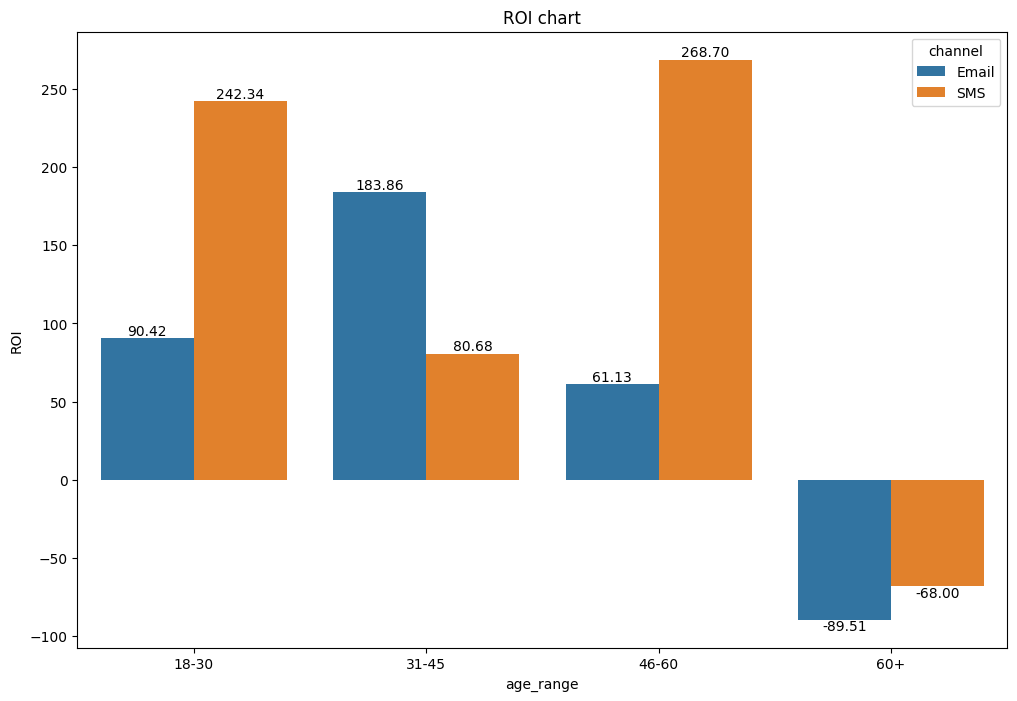

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))
ROI_barplot = sns.barplot(data = analytical_df, x = "age_range", y = "ROI", hue = "channel")
for i in ROI_barplot.containers:
    ROI_barplot.bar_label(i,fmt="%.2f",label_type="edge")
plt.title("ROI chart")

Comments:
Base on the ROI chart and sum_of_net_profit chart, we can evaluate effectiveness of each chanel in each Customer segment
- Customer group 60+ have negative ROI and sum_of_net_profit in both Email and SMS channel, then we definitely exclude this group from our advertising campaign
- SMS Channel in Customer group 46-60 is the the best chanel
- The second-best, third-best, forth-best channel is SMS channel in Customer group 18-30, Email channel in Customer group 31 - 45, Email channel in Customer group 18-30, respectively

Text(0.5, 1.0, 'CVR chart')

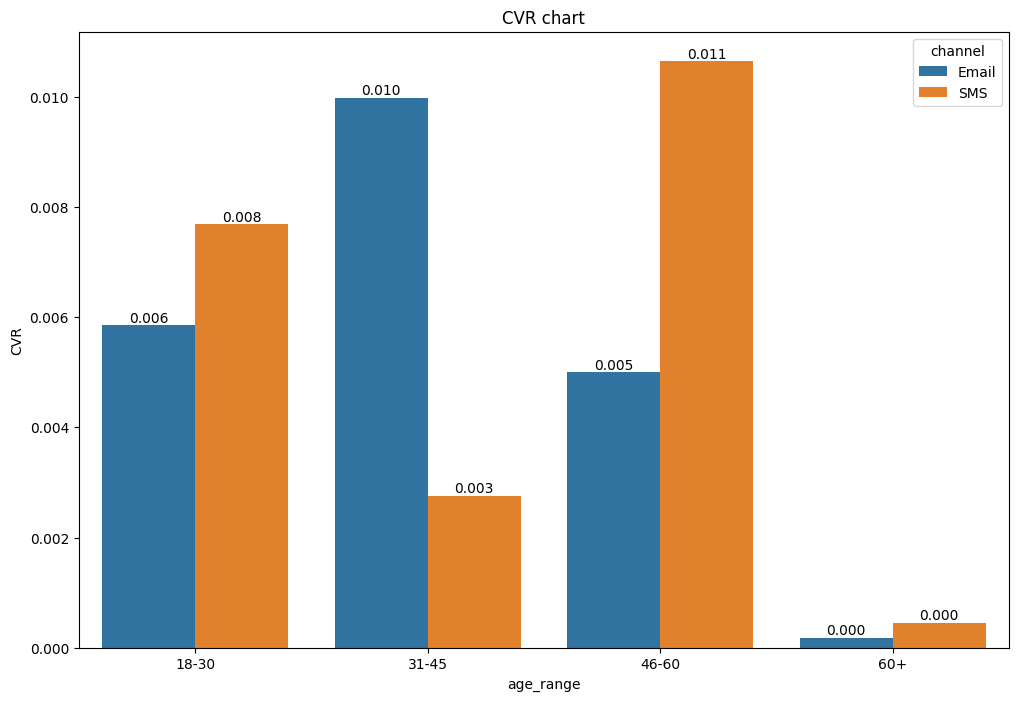

In [32]:
fig, ax = plt.subplots(figsize = (12,8))
CVR_barplot = sns.barplot(data = analytical_df, x = "age_range", y = "CVR", hue= "channel")
for i in CVR_barplot.containers:
    CVR_barplot.bar_label(i,fmt= "%.3f",label_type="edge")
plt.title("CVR chart")

Comments:
This chart describes CVR of each customer segment and each channel. Base on the chart, we can also evaluate effectiveness of each chanel in each Customer segment
- Customer group 60+ have the very small CVR, then we exclude this group from advertising campaign.
- SMS Channel in Customer group 46-60 is still the the best chanel
- The second-best, third-best, forth-best channel is SMS channel in Customer group 31 - 45, SMS channel in Customer group 18 - 30, Email channel in Customer group 18-30, respectively

Take a note that there is a small difference in ROI chart and CVR chart about rank number 2 and number 3.
Although CRV of Email channel in Customer group 31 - 45  is higher than SMS channel in Customer group 18 - 30's, ROI is lower than the other's.
We are interested in the ROI more so that SMS channel in Customer group 18 - 30 takes  the second priority after SMS Channel in Customer group 46-60

In summary, the order of priority for allocating budget is:
- 1.SMS Channel in Customer group 46-60
- 2.SMS channel in Customer group 18 - 30
- 3.Email channel in Customer group 31 - 45.
We implement allocating with order of priority until remaining_budget = 0

For the next quarter, we has a budget of $60,000 to spend on online campaigns. Assume that we have potential customer pool for each age group as below:
Age Group Pool size
- 18 - 30 300,000
- 31 - 45 350,000
- 46 - 60 500,000
- 60+     200,000

Then we allocate budge as below:

In [33]:
Segment = []
list_quantity = []
Segment_budget = []
order_of_priority = [("46-60 SMS",500000,0.05),("18-30 SMS",300000,0.05),("31-45 Email",350000,0.075)]
remaining_budget = 60000
allocated_budget = 0
for i in order_of_priority:
	if remaining_budget >= i[1]*i[2]:
		allocated_budget += i[1]*i[2]
		remaining_budget-= i[1]*i[2]
		Segment.append(i[0])
		list_quantity.append(i[1])
		Segment_budget.append(i[1]*i[2])
		print("age_range",i[0].split(" ")[0],"Total of ", i[0].split(" ")[1],i[1], "Allocated budget for this group is",i[1]*i[2])
	else:
		Quantity_of_last_group = int(remaining_budget/i[2])
		budget_for_this_group = Quantity_of_last_group*i[2]
		Segment.append(i[0])
		list_quantity.append(Quantity_of_last_group)
		Segment_budget.append(budget_for_this_group)
		print("age_range",i[0].split(" ")[0],"Total of ",i[0].split(" ")[1], Quantity_of_last_group,"Allocated budget for this group is",budget_for_this_group)
	if remaining_budget <= 0.05: # Remaining budget is not enough for the cost of an SMS, exit the loop
		break

age_range 46-60 Total of  SMS 500000 Allocated budget for this group is 25000.0
age_range 18-30 Total of  SMS 300000 Allocated budget for this group is 15000.0
age_range 31-45 Total of  Email 266666 Allocated budget for this group is 19999.95


We create dataframe of allocation

In [34]:
allocate_df = pd.DataFrame(list(zip(Segment,list_quantity,Segment_budget)),columns=["Segment","Quantity","Segment_budget"])
allocate_df

,Segment,Quantity,Segment_budget
0,46-60 SMS,500000,25000.00
1,18-30 SMS,300000,15000.00
2,31-45 Email,266666,19999.95


Now we plot the chart for describing the percentage of allocation

Text(0.5, 1.0, 'Percentage Of Allocation')

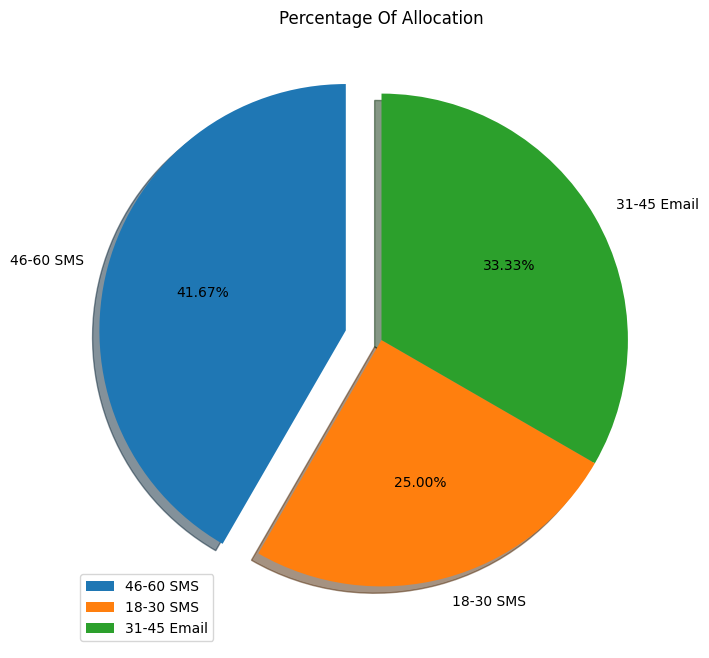

In [35]:
fig, ax = plt.subplots(figsize = (8,8))
plt.pie(data= allocate_df, x= "Segment_budget", labels= "Segment", autopct='%.2f%%', startangle= 90, explode= [0.15,0,0], shadow=True)
plt.legend(allocate_df["Segment"], loc = "lower left")
plt.title("Percentage Of Allocation")